In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import geopy.distance
import os
import plotly.graph_objects as go
from shapely.geometry import shape, Point
import seaborn as sns
import matplotlib as mpl
import folium
import re
import seaborn as sns
from datetime import datetime
import pytz
from pytz import timezone
#from google.colab import drive
import datetime


In [123]:
#from google.colab import drive
#drive.mount('/content/drive')
df = pd.read_excel('Session-Details-Summary-20240119-3.xlsx')

In [124]:
missing_count = df['Port Type'].value_counts().get('Missing', 0)
print(f"Number of missing values in 'Port Type': {missing_count}")

Number of missing values in 'Port Type': 0


In [125]:
unique_values_time_zone = df['Start Time Zone'].unique()
print(unique_values_time_zone)

['EST' 'CST' 'PST' 'CDT' 'EDT' 'PDT']


# Convert Start and End Date to datetime

In [126]:
df['Start Date'] = pd.to_datetime(df['Start Date'])
df['End Date'] = pd.to_datetime(df['End Date'])

def convert_to_est(row, date_col, tz_col):
    tz_map = {'EST': 'America/New_York', 'CST': 'America/Chicago', 'CDT': 'America/Chicago', 'EDT': 'America/New_York', 'PDT': 'America/Los_Angeles', 'PST': 'America/Los_Angeles'}
    return row[date_col].tz_localize(tz=tz_map[row[tz_col]], ambiguous='NaT').tz_convert(tz='EST')


# Apply function to Start and End Date
df['Start_Time_EST'] = df.apply(convert_to_est, args=('Start Date', 'Start Time Zone'), axis=1)
df['End_Time_EST'] = df.apply(convert_to_est, args=('End Date', 'End Time Zone'), axis=1)

In [127]:
def convert_duration_to_seconds(duration):
    if isinstance(duration, str):
        parts = duration.split(':')
        hours = int(parts[0])
        minutes = int(parts[1])
        seconds = int(parts[2].split()[0])  # Extract seconds and ignore 'AM' or 'PM'
        total_seconds = hours * 3600 + minutes * 60 + seconds
        return total_seconds
    elif isinstance(duration, datetime.time):
        return duration.hour * 3600 + duration.minute * 60 + duration.second
    else:
        return 0  # Handle other cases if needed

In [128]:
df['Total Duration'] = df['Total Duration (hh:mm:ss)'].apply(convert_duration_to_seconds)
df['Charging Time'] = df['Charging Time (hh:mm:ss)'].apply(convert_duration_to_seconds)

In [129]:
count = (df['Charging Time'] > df['Total Duration']).sum()
count

107

In [130]:
df.loc[df['Charging Time'] > df['Total Duration'], 'Charging Time'] = df['Total Duration']

In [133]:
df['Time_Difference'] = df['Total Duration'] - df['Charging Time']


In [134]:
df['Time_Difference'].describe()

count    38624.000000
mean      1426.306804
std       5571.574125
min          0.000000
25%         20.000000
50%         35.000000
75%        117.000000
max      75828.000000
Name: Time_Difference, dtype: float64

In [135]:
count_117 = (df['Time_Difference'] > 117).sum()
count_15_min_more = (df['Time_Difference'] > 900).sum()
count_60_min_more = (df['Time_Difference'] > 3600).sum()

print(f"Number of charging time with more than 117 sec: {count_117}")
print(f"Number of charging time with more than 900 sec- 15min: {count_15_min_more}")
print(f"Number of charging time with more than 3600 sec- 60min: {count_60_min_more}")

Number of charging time with more than 117 sec: 9633
Number of charging time with more than 900 sec- 15min: 4841
Number of charging time with more than 3600 sec- 60min: 3061


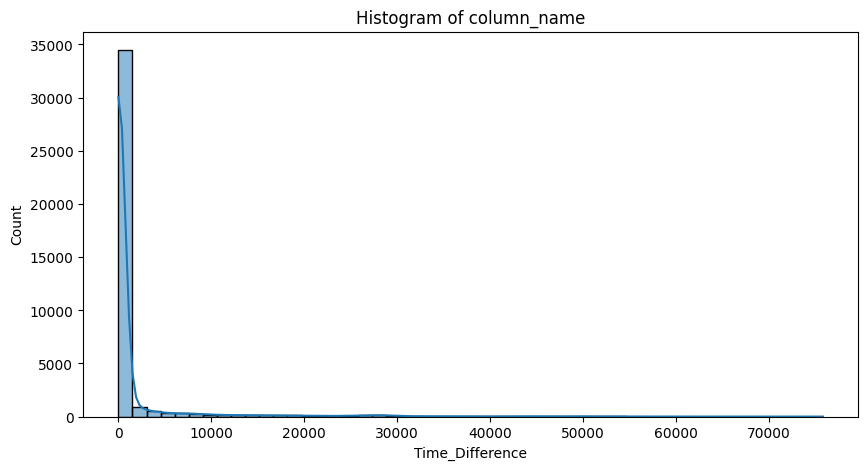

In [136]:
plt.figure(figsize=(10, 5))
sns.histplot(df['Time_Difference'], bins=50, kde=True)
plt.title('Histogram of column_name')
plt.show()



In [137]:
charging_time = df['Charging Time']
charging_time_in_hours = charging_time / 3600
charging_time_in_hours.describe()

count    38624.000000
mean         1.503110
std          2.041753
min          0.000000
25%          0.240556
50%          0.744583
75%          1.885972
max         21.887222
Name: Charging Time, dtype: float64

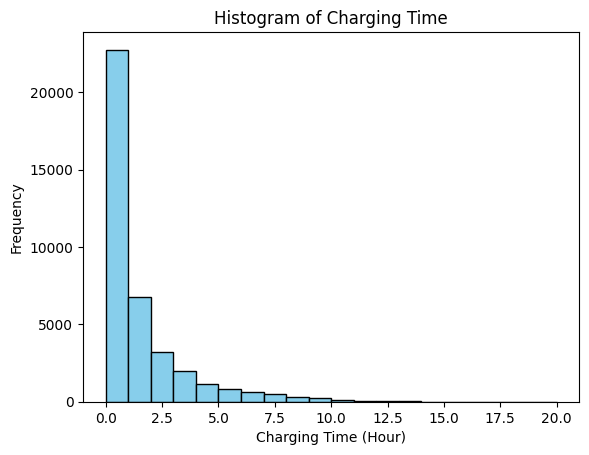

In [20]:
charging_time = df['Charging Time']

# Convert timedelta to hour for easier visualization
charging_time_in_hours = charging_time / 3600

# Plot histogram
plt.hist(charging_time_in_hours, bins=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], color='skyblue', edgecolor='black')
plt.title('Histogram of Charging Time')
plt.xlabel('Charging Time (Hour)')
plt.ylabel('Frequency')
plt.show()

In [138]:
unique_values_port_type = df['Port Type'].unique()

# Count occurrences of each unique value
port_type_counts = df['Port Type'].value_counts()

# Print unique values
print("Unique Values:", unique_values_port_type)

# Print counts of each unique value
print("Number of charging events")
print(port_type_counts)


Unique Values: ['Level 2' 'DC Fast' nan]
Number of charging events
Port Type
Level 2    21490
DC Fast    15453
Name: count, dtype: int64


In [139]:
# Convert 'Start_Time_EST' to datetime if it's not already
df['Start_Time_EST'] = pd.to_datetime(df['Start_Time_EST'])

# Create a new column 'Day_of_Week' that represents the day of the week
df['Day_of_Week'] = df['Start_Time_EST'].dt.dayofweek

# Create new columns 'Is_Weekday' and 'Is_Weekend'
df['Is_Weekday'] = df['Day_of_Week'].isin([0, 1, 2, 3, 4]).astype(int)
df['Is_Weekend'] = df['Day_of_Week'].isin([5, 6]).astype(int)

In [140]:
# Create new columns 'DC' and 'L2'
df['DC'] = (df['Port Type'] == 'DC Fast').astype(int)
df['L2'] = (df['Port Type'] == 'Level 2').astype(int)

In [141]:
df['Port Type'] = df['Port Type'].fillna('')

df_L2 = df[df['Port Type'].str.fullmatch('Level 2')]
df_DC = df[df['Port Type'].str.fullmatch('DC Fast')]


In [142]:
df['Station Name'] = df['Station Name'].replace({"7SPC / BR-JC LIBRARY": "7SPC / BR-JC LIBRARY_combined","7SPC / BR - JC LIBRARY": "7SPC / BR-JC LIBRARY_combined"})

In [143]:
df['Start_Time_EST']=pd.to_datetime(df['Start_Time_EST'])
df=df.sort_values(by=['Station Name', 'Start_Time_EST'])

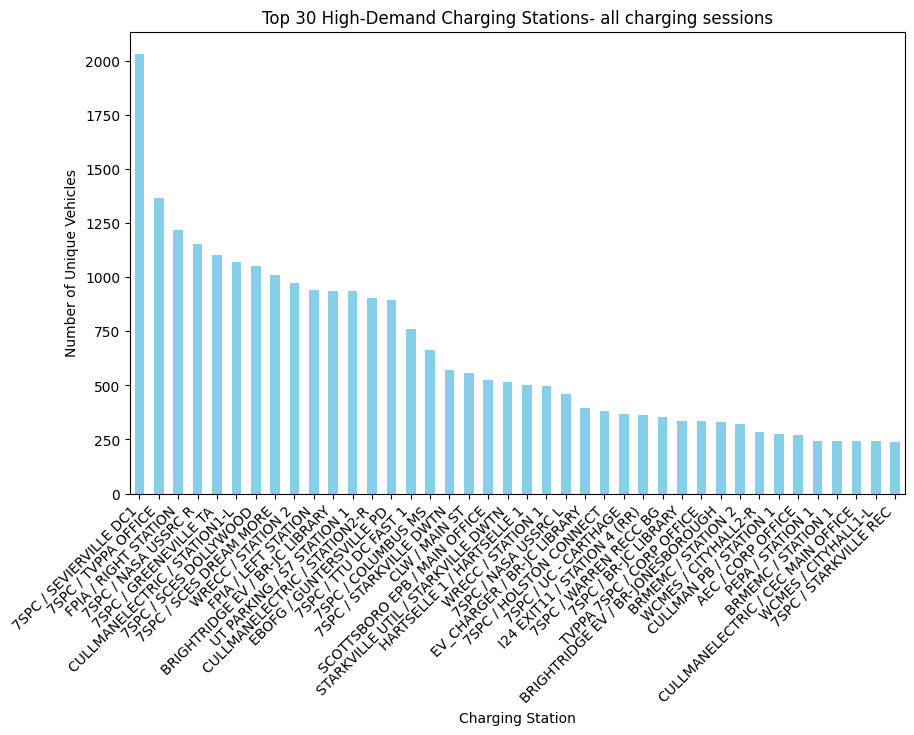

In [106]:
vehicles_per_station_all = df.groupby('Station Name')['User ID'].count()
top_30_stations_all = vehicles_per_station_all.sort_values(ascending=False).head(40)

# Plotting
plt.figure(figsize=(10, 6))
top_30_stations_all.plot(kind='bar', color='skyblue')
plt.title('Top 30 High-Demand Charging Stations- all charging sessions')
plt.xlabel('Charging Station')
plt.ylabel('Number of Unique Vehicles')
plt.xticks(rotation=45, ha='right')
plt.show()

**Take a look at the highest demand CS**

```
# This is formatted as code
```



**calculate the unique 'User ID' and sum of 'Charging Time'**

In [ ]:
df['Start Date'] = pd.to_datetime(df['Start Date']).dt.date


new_df_unique_users = df.groupby(['Station Name', 'Start Date']).agg({'User ID': pd.Series.nunique, 'Charging Time': 'sum'}).reset_index()


new_df_unique_users.columns = ['Station Name', 'Date', 'Unique User Count', 'Total Charging Time']




**All Users in a dayt**

In [70]:

df['Start_Time_EST'] = pd.to_datetime(df['Start_Time_EST']).dt.date

new_df = df.groupby(['Station Name', 'Start_Time_EST']).agg({'User ID': 'count', 'Charging Time': 'sum', 'Total Duration':'sum', 'Energy (kWh)':'sum',
                                                             'Gasoline Savings (gallons)':'sum','GHG Savings (kg)':'sum', 'Fee':'sum'}).reset_index()


new_df['Charging Time'] = new_df['Charging Time'] / 3600
new_df['Total Duration'] = new_df['Total Duration'] / 3600

new_df.columns = ['Station Name', 'Date', 'User Count', 'Total Charging Time (hours)', 'Total Duration Time (hours)','Total Energy (kWh)', 'Total Gasoline Savings (gallons)',
                  'Total GHG Savings (kg)', 'Total Fee']

#new_df['Station Name'] = new_df['Station Name'].replace({"7SPC / BR-JC LIBRARY": "7SPC / BR-JC LIBRARY_combined","7SPC / BR - JC LIBRARY": "7SPC / BR-JC LIBRARY_combined"})

In [69]:

#new_df.to_excel('/content/drive/MyDrive/Colab Notebooks/SevenStates_project/new_dataframe_Day_by_day.xlsx', index=False)


In [71]:
# Group by 'Station Name' and find the index of max 'Total Charging Time (hours)'
idx = new_df.groupby('Station Name')['Total Charging Time (hours)'].idxmax()

highest_charging_time = new_df.loc[idx, ['Station Name', 'Date', 'Total Charging Time (hours)']]





In [72]:
highest_charging_time.describe()

,Total Charging Time (hours)
count,153.000000
mean,8.535312
std,7.042616
min,0.000000
25%,2.538333
50%,6.738889
75%,12.924444
max,27.782222


In [57]:
idx_Energy=new_df.groupby('Station Name')['Total Energy (kWh)'].idxmax()
highest_enrgy_=new_df.loc[idx_Energy,['Station Name', 'Date', 'Total Energy (kWh)']]

NameError: name 'new_df' is not defined

In [26]:
highest_enrgy_.describe()

,Total Energy (kWh)
count,152.000000
mean,99.054967
std,68.390913
min,0.000000
25%,54.085000
50%,85.525000
75%,137.285250
max,315.067000


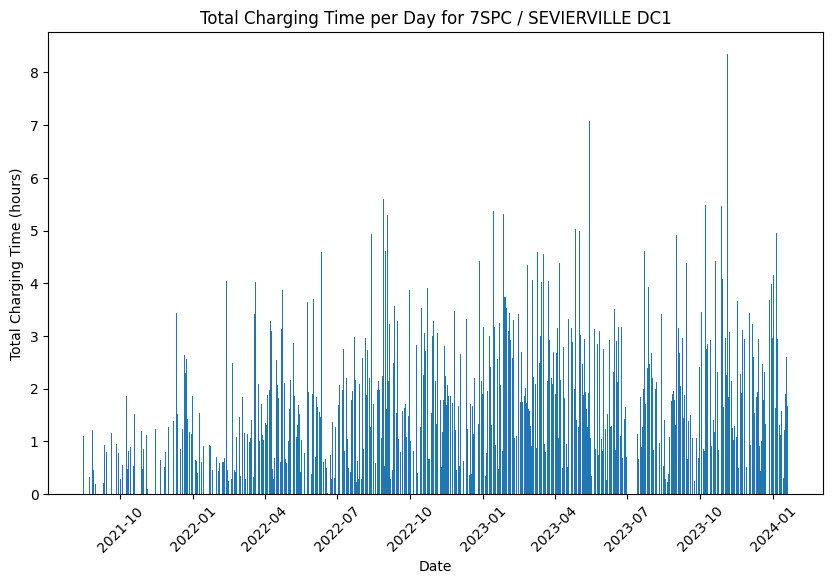

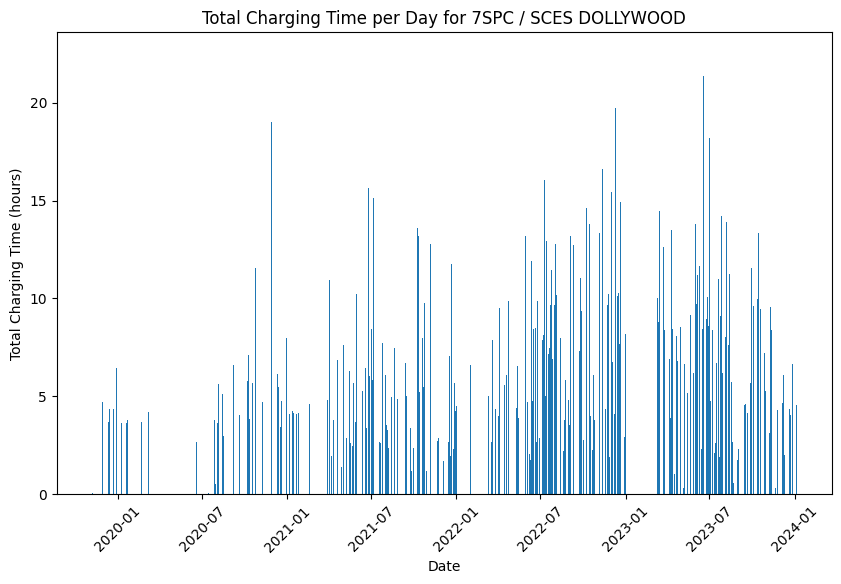

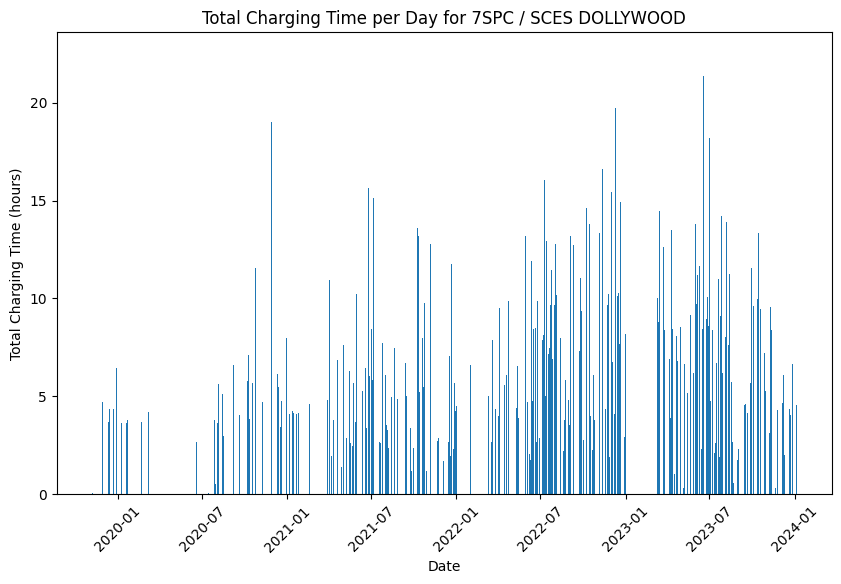

In [73]:
stations = ["7SPC / SEVIERVILLE DC1", "7SPC / SCES DOLLYWOOD", "7SPC / SCES DOLLYWOOD"]

for station in stations:

    df_station = new_df[new_df['Station Name'] == station]


    plt.figure(figsize=(10,6))
    plt.bar(df_station['Date'], df_station['Total Charging Time (hours)'])
    plt.xlabel('Date')
    plt.ylabel('Total Charging Time (hours)')
    plt.title(f'Total Charging Time per Day for {station}')
    plt.xticks(rotation=45)
    plt.show()
    print('\n\n')


In [26]:
# df['Start_Time_EST']=pd.to_datetime(df['Start_Time_EST'])
# df_sorted=df.sort_values(by=['Station Name', 'Start_Time_EST'])

In [107]:
df.columns

Index(['Station Name', 'MAC Address', 'Org Name', 'Start Date',
       'Start Time Zone', 'End Date', 'End Time Zone',
       'Transaction Date (Pacific Time)', 'Total Duration (hh:mm:ss)',
       'Charging Time (hh:mm:ss)', 'Energy (kWh)', 'GHG Savings (kg)',
       'Gasoline Savings (gallons)', 'Port Type', 'Port Number', 'Plug Type',
       'EVSE ID', 'Address 1', 'Address 2', 'City', 'State/Province',
       'Zip/Postal Code', 'Country', 'Latitude', 'Longitude', 'Currency',
       'Fee', 'Ended By', 'Ended By.1', 'Transaction ID',
       'Driver Zip/Postal Code', 'User ID', 'Start SOC', 'End SOC', 'County',
       'System S/N', 'Model Number', 'OnRamp ID Tag',
       'Payment Terminal Session ID', 'Vehicle MAC ID', 'Start_Time_EST',
       'End_Time_EST', 'Total Duration', 'Charging Time', 'Time_Difference',
       'Day_of_Week', 'Is_Weekday', 'Is_Weekend', 'DC', 'L2'],
      dtype='object')

### calculate the time difference between the start time of the current session and the end time of the previous one 

In [144]:
df['End_Time_EST'] = pd.to_datetime(df['End_Time_EST'], utc=True).dt.tz_convert('EST')
df['Start_Time_EST'] = pd.to_datetime(df['Start_Time_EST'], utc=True).dt.tz_convert('EST')

df['previous_end_time'] = df.groupby('Station Name')['End_Time_EST'].shift(1)

first_rows_mask = df['Station Name'] != df['Station Name'].shift(1)
df.loc[first_rows_mask, 'previous_end_time'] = df['Start_Time_EST']

df['time_difference_session'] = df['Start_Time_EST'] - df['previous_end_time']

print(df[['Start_Time_EST', 'End_Time_EST', 'previous_end_time', 'time_difference_session']])




                 Start_Time_EST              End_Time_EST  \
37910 2019-09-26 13:13:13-05:00 2019-09-26 13:30:38-05:00   
37909 2019-09-26 13:49:44-05:00 2019-09-26 13:49:54-05:00   
37908 2019-09-26 14:26:52-05:00 2019-09-26 14:47:58-05:00   
37903 2019-09-26 14:48:27-05:00 2019-09-26 18:03:59-05:00   
37905 2019-09-26 15:05:09-05:00 2019-09-26 15:14:05-05:00   
...                         ...                       ...   
210   2024-01-14 13:30:09-05:00 2024-01-14 13:48:21-05:00   
207   2024-01-14 13:54:57-05:00 2024-01-14 14:12:07-05:00   
131   2024-01-16 06:31:50-05:00 2024-01-16 06:51:56-05:00   
95    2024-01-17 10:29:52-05:00 2024-01-17 11:36:14-05:00   
31    2024-01-18 15:40:28-05:00 2024-01-18 16:28:32-05:00   

              previous_end_time time_difference_session  
37910 2019-09-26 13:13:13-05:00         0 days 00:00:00  
37909 2019-09-26 13:30:38-05:00         0 days 00:19:06  
37908 2019-09-26 13:49:54-05:00         0 days 00:36:58  
37903 2019-09-26 14:47:58-05:00    

### Count the number of cases where previous_end_time > Start_Time_EST

In [146]:
negative_time_differences = df[df['previous_end_time'] > df['Start_Time_EST']]

num_negative_time_differences = len(negative_time_differences)

print("Number of cases where previous_end_time > Start_Time_EST:", num_negative_time_differences)


Number of cases where previous_end_time > Start_Time_EST: 2761


In [145]:
unique_stations = df['Station Name'].unique()

for station in unique_stations:
    specific_station_df = df[df['Station Name'] == station]
    
    average_time_difference_between_sessions = specific_station_df['time_difference_session'].mean()
    
    print(f"average time difference between sessions {station}: {average_time_difference_between_sessions}")


average time difference between sessions 7SPC / BR-JC LIBRARY_combined: 1 days 05:21:10.970666666
average time difference between sessions 7SPC / BR-JONESBOROUGH: 9 days 07:33:00.296296296
average time difference between sessions 7SPC / CFEC SPENCER: 18 days 13:37:41.290322580
average time difference between sessions 7SPC / COLUMBUS L&W: 0 days 21:29:03.642857142
average time difference between sessions 7SPC / COLUMBUS MS: 1 days 06:12:57.949928469
average time difference between sessions 7SPC / CULLMAN PB: 5 days 10:32:22.195121951
average time difference between sessions 7SPC / DOLLYWOOD EMPL: 5 days 19:46:11.461538461
average time difference between sessions 7SPC / GREENEVILLE TA: 0 days 23:51:12.457561728
average time difference between sessions 7SPC / GUNTERSVILLE PD: 4 days 14:29:37.561904761
average time difference between sessions 7SPC / HARTSELLE UTIL: 3 days 21:02:33.112903225
average time difference between sessions 7SPC / HOLSTON CONNECT: 1 days 09:43:31.973890339
average t

### End charging time

In [111]:
df['Charging Time (hh:mm:ss)'] = df['Charging Time (hh:mm:ss)'].apply(lambda x: pd.to_timedelta(x.strftime('%H:%M:%S')) if x != datetime.time(0, 0) else pd.Timedelta(seconds=0))

df['End_charging_time'] = df['Start_Time_EST'] + df['Charging Time (hh:mm:ss)']





In [112]:
columns = ['Station Name', 'MAC Address', 'Org Name', 'Address 1', 'City', 'State/Province',
           'Zip/Postal Code', 'Driver Zip/Postal Code', 'User ID', 'Latitude', 'Longitude', 'Port Type', "DC", "L2" ,
           'Start_Time_EST','End_charging_time', 'End_Time_EST', 'time_difference_session','Total Duration','Charging Time',
           'Time_Difference',"previous_end_time","Is_Weekday","Is_Weekend", 'Total Duration (hh:mm:ss)', 'Charging Time (hh:mm:ss)',
           'Energy (kWh)', 'GHG Savings (kg)', 'Gasoline Savings (gallons)', 'Fee', 'Start SOC', 'End SOC',
           'System S/N', 'Model Number', 'Vehicle MAC ID','Port Number','Plug Type','EVSE ID', 'Ended By']

# Create a new DataFrame for ML
df = df[columns]

In [113]:
#df_sorted_ordered.to_csv('df_sorted_ordered.csv', index=False)

In [114]:
df.reset_index(drop=True, inplace=True)

In [115]:
df

,Station Name,MAC Address,Org Name,Address 1,City,State/Province,Zip/Postal Code,Driver Zip/Postal Code,User ID,Latitude,...,Fee,Start SOC,End SOC,System S/N,Model Number,Vehicle MAC ID,Port Number,Plug Type,EVSE ID,Ended By
0,7SPC / BR - JC LIBRARY,0024:B100:0003:7806,Seven States Power Corp,201 N Roan St,Johnson City,Tennessee,37601,37687,4407231,36.319176,...,0.00,NaN,NaN,192441014614,CT4020-HD-GW,NaN,2,J1772,1932851,Plug Out at Vehicle
1,7SPC / BR - JC LIBRARY,0024:B100:0003:7806,Seven States Power Corp,201 N Roan St,Johnson City,Tennessee,37601,30703,2770771,36.319176,...,0.00,NaN,NaN,192441014614,CT4020-HD-GW,NaN,1,J1772,1932851,Customer
2,7SPC / BR - JC LIBRARY,0024:B100:0003:7806,Seven States Power Corp,201 N Roan St,Johnson City,Tennessee,37601,37687,4407231,36.319176,...,0.00,NaN,NaN,192441014614,CT4020-HD-GW,NaN,2,J1772,1932851,Plug Out at Vehicle
3,7SPC / BR - JC LIBRARY,0024:B100:0003:7806,Seven States Power Corp,201 N Roan St,Johnson City,Tennessee,37601,37687,4407231,36.319176,...,2.00,NaN,NaN,192441014614,CT4020-HD-GW,NaN,2,J1772,1932851,Plug Out at Vehicle
4,7SPC / BR - JC LIBRARY,0024:B100:0003:7806,Seven States Power Corp,201 N Roan St,Johnson City,Tennessee,37601,30703,2770771,36.319176,...,0.14,NaN,NaN,192441014614,CT4020-HD-GW,NaN,1,J1772,1932851,Customer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38619,WRECC / STATION 2,0024:B100:0008:00F2,Warren RECC,675 Western Kentucky Pkwy,Beaver Dam,Kentucky,42320,37069,36139071,37.377178,...,7.21,0.27,0.55,220515001917,CPE250C-500-CCS1-CHD,98ed5ca74f87,1A,Combo,12720861,Plug Out at Station
38620,WRECC / STATION 2,0024:B100:0008:00F2,Warren RECC,675 Western Kentucky Pkwy,Beaver Dam,Kentucky,42320,37069,36139071,37.377178,...,6.54,0.55,0.83,220515001917,CPE250C-500-CCS1-CHD,98ed5ca74f87,1A,Combo,12720861,ProximityLost
38621,WRECC / STATION 2,0024:B100:0008:00F2,Warren RECC,675 Western Kentucky Pkwy,Beaver Dam,Kentucky,42320,40204,34152541,37.377178,...,8.02,0.27,0.44,220515001917,CPE250C-500-CCS1-CHD,706979c03319,1A,Combo,12720861,Plug Out at Station
38622,WRECC / STATION 2,0024:B100:0008:00F2,Warren RECC,675 Western Kentucky Pkwy,Beaver Dam,Kentucky,42320,NaN,452481V,37.377178,...,20.50,0.16,0.92,220515001917,CPE250C-500-CCS1-CHD,481693e75213,1A,Combo,12720861,Plug Out at Station
